In [1]:
from sympy.abc import s, z
from control import matlab as m
import sympy as sp

gp = 0.3333/(.043*s+1)
gp

0.3333/(0.043*s + 1)

In [2]:
from utils.units.sympy_helpers import var_in
from utils.units import u, basis

gp = var_in(s, u.rad/u.s, gp)
gp

0.3333/(1 + 0.043*second*s/radian)

In [3]:
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=2603739216327729285), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [4]:
mp_pi = 5*u.percent
mp_pid = 2*u.percent
ts = 0.45*u.s

In [5]:
def poles_rise_time(p):
    return sp.arg(p)/p.imag

In [6]:
from utils.ctrlsys import pole_specs
tr = nu.to_symb(u.s, poles_rise_time(pole_specs(nu[ts], nu[mp_pid])[1]))
dt = tr/10
dt.n(4)

0.03531*second

In [7]:
from utils.ctrl import expr2sys
gp_tf = expr2sys(nu.to_numeric(gp, as_expr=True), s)
gp_tf

TransferFunction(array([0.3333]), array([5.98075601e-04, 1.00000000e+00]))

In [8]:
gp_dtf = m.c2d(gp_tf, nu[dt])
gp_dtf

TransferFunction(array([0.18666911]), array([ 1.        , -0.43993667]), 0.0004910945320732887)

Planta discretizada

In [9]:
from utils.ctrl import sys2expr
gp_d = sys2expr(gp_dtf, z)
gp_d

0.18666910947471/(1.0*z - 0.439936665242394)

In [10]:
gd_d = gp_d * 1/z
gd_d

0.18666910947471/(z*(1.0*z - 0.439936665242394))

In [11]:
gd_dtf = expr2sys(gd_d, z)
gd_dtf.dt = nu[dt]
gd_dtf

TransferFunction(array([0.18666911]), array([ 1.        , -0.43993667,  0.        ]), 0.0004910945320732887)

Ley de control para el PI

In [12]:
k_pi, a_pi = sp.symbols("K_{pi} a_{pi}", real=True)
gc_d_pi = k_pi*(z-a_pi)/(z-1)
gc_d_pi

K_{pi}*(-a_{pi} + z)/(z - 1)

Ley de control para el PD

In [13]:
k_pd, a_pd = sp.symbols("K_{pd} a_{pd}", real=True)
gc_d_pd = k_pd*(z-a_pd)/z
gc_d_pd

K_{pd}*(-a_{pd} + z)/z

In [14]:
from utils.ctrlsys import pole_specs
_, dp_s_pi = pole_specs(nu[ts], nu[mp_pi])
nu.to_symb(u.rad/u.s, dp_s_pi)

radian*(-8.69338445650699 + 9.11666005153175*I)/second

Polos deseados en Z para el controlador PI

In [15]:
from utils.ctrlsys import z_map
dp_pi = z_map(dp_s_pi, nu[dt])
dp_pi

(0.6979015277893713+0.23274528220286603j)

In [16]:
def rlocus_cond(dp, z, fb):
    return fb.subs(z, dp)+1


Parámetros calculados mediante LGR

In [17]:
from utils.math import sp_reim as reim
from utils.sympy_helpers import nsolve

pi_params = nsolve(
    reim(rlocus_cond(dp_pi, z, gd_d*gc_d_pi)),
    {k_pi: 1, a_pi: 1})

sp.Dict(pi_params)

{K_{pi}: 0.872678245033096, a_{pi}: 0.146632503479854}

Ajuste "por SISOTOOL"

In [49]:
from utils.ctrlsys import autotune
from utils.misc import valmap

opt_result, pi_tuned_params = autotune(
    valmap(float, pi_params),
    z, m.tf("z"),
    gc_d_pi,
    nu[mp_pi]*.9, nu[ts]*.9,
    gd_dtf,
    1, as_dict=True,
    return_optimize_result=True)

opt_result

    fjac: array([[-0.99986688,  0.01631605],
       [-0.01631605, -0.99986688]])
     fun: array([-2.09660067e-12, -6.80731513e-14])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([4.73192083e-11, 2.52921163e-12])
       r: array([ 0.18689768, -0.65533113, -0.0123519 ])
  status: 1
 success: True
       x: array([1.27867575, 0.32480448])

In [50]:
sp.Dict(pi_tuned_params)

{K_{pi}: 1.27867575355517, a_{pi}: 0.32480447669314}

In [51]:
gc_pi_dtf = expr2sys(gc_d_pi.subs(pi_tuned_params), z)
gc_pi_dtf_nt = expr2sys(gc_d_pi.subs(pi_params), z)

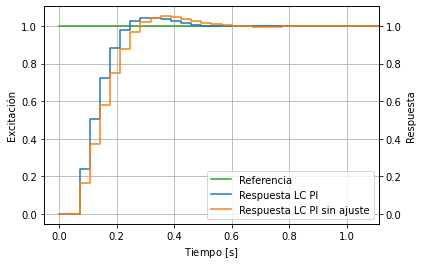

In [52]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp
from utils.mpl import set_datalim

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

plot_step(
    m.feedback(gd_dtf*gc_pi_dtf), label="Respuesta LC PI")
plot_step(
    m.feedback(gd_dtf*gc_pi_dtf_nt), label="Respuesta LC PI sin ajuste")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
set_datalim(ax_e, x=(0, nu[dt*30]))
ax_e.grid()
set_gain_and_legend_loc(1, "lower right")

In [53]:
gc_pi_dtf = expr2sys(gc_d_pi.subs(pi_tuned_params), z)
gc_pi_dtf

TransferFunction(array([ 1.27867575, -0.41531961]), array([ 1., -1.]), True)

Polos deseados con el controlador PID

In [54]:
_, dp_s_pid = pole_specs(nu[ts], nu[mp_pid])
nu.to_symb(u.rad/u.s, dp_s_pid)

radian*(-8.69338445650699 + 6.98131700797732*I)/second

In [55]:
dp_pid = z_map(dp_s_pid, nu[dt])
dp_pid

(0.713450180183765+0.17951531765892217j)

In [56]:
pd_params = nsolve(
    reim(rlocus_cond(dp_pid, z, gd_d*gc_d_pi.subs(pi_tuned_params)*gc_d_pd)),
    {k_pd: -1, a_pd: .5})

sp.Dict(pd_params)

{K_{pd}: 0.2655599160171, a_{pd}: -1.48572074158365}

In [66]:
opt_result, pd_tuned_params = autotune(
    valmap(float, pd_params),
    z, m.tf("z"),
    gc_d_pd,
    nu[mp_pid]*.8, nu[ts]*.9,
    gd_dtf*gc_pi_dtf,
    1, as_dict=True, return_optimize_result=True)

opt_result.message

'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'

In [58]:
sp.Dict(pd_tuned_params)

{K_{pd}: 0.322666822906008, a_{pd}: -1.05669304155641}

In [59]:
gc_pd_dtf = expr2sys(gc_d_pd.subs(pd_tuned_params), z)
gc_pd_dtf

TransferFunction(array([0.32266682, 0.34095979]), array([1., 0.]), True)

In [60]:
gcl_pi_dtf = m.feedback(gd_dtf*gc_pi_dtf)
gcl_pid_dtf = m.feedback(gd_dtf*gc_pi_dtf*gc_pd_dtf)

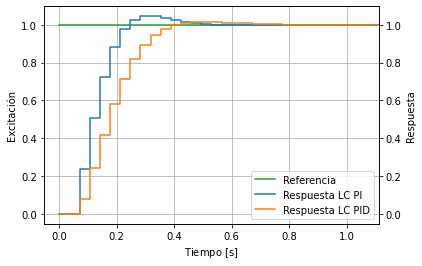

In [61]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

#plot_step(m.feedback(gp_tf), label="Respuesta LC sin controlador")
plot_step(gcl_pi_dtf, label="Respuesta LC PI")
plot_step(gcl_pid_dtf, label="Respuesta LC PID")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
set_datalim(ax_e, x=(0, nu[dt*30]))
ax_e.grid()
set_gain_and_legend_loc(1, "lower right")

In [62]:
from utils.ctrl import nu_stepinfo

nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_pid_dtf))

{'RiseTime': 0.211850122305864*second,
 'SettlingTime': 0.353083537176439*second,
 'SettlingMin': 0.945884860476976,
 'SettlingMax': 1.01599962694722,
 'Overshoot': 1.59996269472225*percent,
 'Undershoot': 0,
 'Peak': 1.01599962694722,
 'PeakTime': 0.494316952047015*second,
 'SteadyStateValue': 1.00000000000000}

In [63]:
nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_pi_dtf))

{'RiseTime': 0.141233414870576*second,
 'SettlingTime': 0.423700244611727*second,
 'SettlingMin': 0.978496951306616,
 'SettlingMax': 1.04500000000211,
 'Overshoot': 4.50000000021089*percent,
 'Undershoot': 0,
 'Peak': 1.04500000000211,
 'PeakTime': 0.282466829741151*second,
 'SteadyStateValue': 1.00000000000000}